# Churn prediction 

In the prior analysis, the Olist customers were segmented and their customer life time value was calculated. This enables Olist to identify their best customers. If these customers were to leave Olist and become a customer in one of Olist competitors then it would hurt Olist revenue. Therefore, it is relevant to conduct a churn analysis in order to identify which customers might churn in the future. Knowing this, Olist can take actions specifik againt the customer likely to churn to keep the customer.



In the following notebook a churn analysis will be carried out. The churn analysis employs survival analysis to predict whether a customer will churn or not. Survival analysis has been chosen because besides giving an idea if a customer is going to stop doing business it also gives a probability for when the event might happen. 







In [1]:
# Standard packages are imported
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline

dirpath = '../data/'

The customer data sets are loaded as in the previous notebook which include Olist_customers,Olist_orders and Olist_order_payments. Futhermore, the order item dataset is joined with the customer data since it could be relevant to use features such as product category for later modelling in the prediction model.

In [2]:
# Load data
customers = pd.read_csv(dirpath+"olist_customers_dataset.csv")
order_payments = pd.read_csv(dirpath+"olist_order_payments_dataset.csv")
orders = pd.read_csv(dirpath+"olist_orders_dataset.csv")
orders_item = pd.read_csv(dirpath+"olist_order_items_dataset.csv")
products = pd.read_csv(dirpath+"olist_products_dataset.csv")
reviews = pd.read_csv(dirpath+"olist_order_reviews_dataset.csv")

# Join
customer_order = customers.merge(orders, on='customer_id', how='left')
order_payments = order_payments.groupby('order_id').sum().reset_index()[['order_id','payment_value']]
cop = customer_order.merge(order_payments, on='order_id', how='left')
cop = cop.merge(orders_item, on='order_id', how='left')
cop = cop.merge(products, on='product_id', how='left')
cop = cop.merge(reviews, on='order_id', how='left')

# clean and format
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])
cop = cop[cop['order_status']!='canceled']

## Data preparation

In [3]:
cop.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,8683.0,54.0,64.0,31.0,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,10150.0,89.0,15.0,40.0,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,8267.0,52.0,52.0,17.0,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,12160.0,56.0,51.0,28.0,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,5200.0,45.0,15.0,35.0,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52


## Data preparation for survival analysis

In survival analysis, a data point is characterised by three elements: $X_i,E_i,T_i, \forall i \in N$ where $N$ is number of datapoints. 

- $X_i$ : is a p-dimensional feature vector
- $E_i$ : is an event indicator. If $E_i = 1$ an event happens, the other case where $E_i=0$ means that the data point is censored because an event does not happen. 
- $T_i$ : $min(t_i,c_i)$ , where $t_i$ is the actual time to event and $c_i$ is time to censoring


In the following section, the data will be preprocessed to be ready for modelling with survival models:

1. An Event-column will be calculated
2.

In [75]:
# Creating a column "number of purchases" and joining it on
df = cop.merge(cop.groupby('customer_unique_id').size().reset_index(), on='customer_unique_id', how='left')

# Getting last date of purchase
t_end = cop.order_purchase_timestamp.max()

# Separating customers with multiple purchases from customers with a single purchase 
df_event_1 = df[df.iloc[:,-1] > 1]
df_event_0 = df[df.iloc[:,-1] < 2]

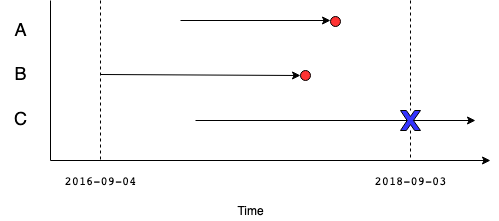

In [76]:
# Calculating the difference between purchasedates (in weeks) of first and following orders of the same customer.   
df_event_1 = df_event_1.groupby('customer_unique_id')['order_purchase_timestamp'].apply(lambda x: x.sort_values()).reset_index()
df_event_1['T'] = (df_event_1.groupby('customer_unique_id')['order_purchase_timestamp'].diff() / np.timedelta64(1, 'W'))
# Removing a customers first purchase from dataframe
df_event_1 = df_event_1.dropna(subset=['T'])
# Rounding up number of weeks
df_event_1['T'] = df_event_1['T'].apply(np.ceil).astype(int)
# Removing purchases with same purchase date and time for a given customers.
df_event_1 = df_event_1[df_event_1['T'] > 0]
# Setting event variable to one
df_event_1['E'] = 1
df_event_1 = df_event_1[['customer_unique_id', 'order_purchase_timestamp','T','E']]

In [78]:
df_event_1.head()

,customer_unique_id,order_purchase_timestamp,T,E
31,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,25,1
35,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,39,1
67,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,2,1
87,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,1,1
115,011575986092c30523ecb71ff10cb473,2018-04-18 21:58:08,9,1


In [51]:
df_event_0['E'] = 0
df_event_0['T'] = ((t_end - df_event_0.order_purchase_timestamp) / np.timedelta64(1, 'W')).apply(np.ceil).astype(int)
df_event_0 = df_event_0[['customer_unique_id', 'order_purchase_timestamp','T','E']]

In [52]:
# Subsetting data
df_event_0 = df_event_0.sample(16000, replace=True)
#df_event_0 = df_event_0[:16000]

In [53]:
# Feature: on time shipping
cop['on_time_delivery'] = (cop.order_delivered_customer_date < cop.order_estimated_delivery_date).astype(int)
df_model['on_time_delivery'].value_counts()

1    17851
0     1990
Name: on_time_delivery, dtype: int64

In [57]:
# Feature: product price category
cat_prices = cop.groupby(['product_category_name']).mean()['price'].sort_values()
q33, q66 = np.quantile(cat_prices, q=[.33,.66])

cop['product_price_cat'] = 'Low-price'
cop.loc[cop['price']>q33,'product_price_cat'] = 'Mid-price' 
cop.loc[cop['price']>q66,'product_price_cat'] = 'High-price' 

In [58]:
# Concatenating data
df_event = pd.concat([df_event_1, df_event_0])

# Joining features on
df_full = df_event.merge(cop, on=['customer_unique_id','order_purchase_timestamp'], how='left')

df_model = df_full[['T','E','customer_state','payment_value','review_score','product_price_cat','on_time_delivery']]
# One-hot encoding categorical features
df_model = pd.get_dummies(data=df_model, columns=['customer_state','product_price_cat'])

In [59]:
df_model.head()

,T,E,payment_value,review_score,on_time_delivery,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,...,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,product_price_cat_High-price,product_price_cat_Low-price,product_price_cat_Mid-price
0,25,1,103.28,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,39,1,49.85,5,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,1,26.78,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,81.78,5,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,1,1,81.78,3,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


The distribution of the customers who churned/not-churned are shown below.

In [60]:
df_full.E.value_counts()

0    16000
1     3841
Name: E, dtype: int64

In [34]:
#count of how many times each product category has been bought
df_full.product_category_name.value_counts()

cama_mesa_banho                                  1965
beleza_saude                                     1787
esporte_lazer                                    1562
informatica_acessorios                           1350
moveis_decoracao                                 1291
relogios_presentes                               1172
utilidades_domesticas                            1167
telefonia                                         810
automotivo                                        786
cool_stuff                                        732
brinquedos                                        727
ferramentas_jardim                                636
perfumaria                                        629
bebes                                             541
eletronicos                                       456
papelaria                                         429
fashion_bolsas_e_acessorios                       418
pet_shop                                          322
moveis_escritorio           

The data is checked for Null values and and duplicates

In [35]:
N_null = sum(df_model.iloc[:,2:].isnull().sum())
N_dupli = sum(df_model.iloc[:,2:].duplicated(keep='first'))
print('The raw_dataset contains {} null values.'.format(N_null))
print('The dataset contains {} duplicates.'.format(N_dupli))

The raw_dataset contains 0 null values.
The dataset contains 3098 duplicates.


As a final step in the data preparation, the data is standardised by subtracting the mean and dividing with the std.

In [36]:
mu = df_model.payment_value.mean()
sigma = df_model.payment_value.std()
df_model.payment_value = (df_model.payment_value - mu)/sigma # standardization of data
df_model = df_model.dropna()

It is relevant to see the correlation between the chosen features. This can be done through pysurvivals correlation_matrix function.

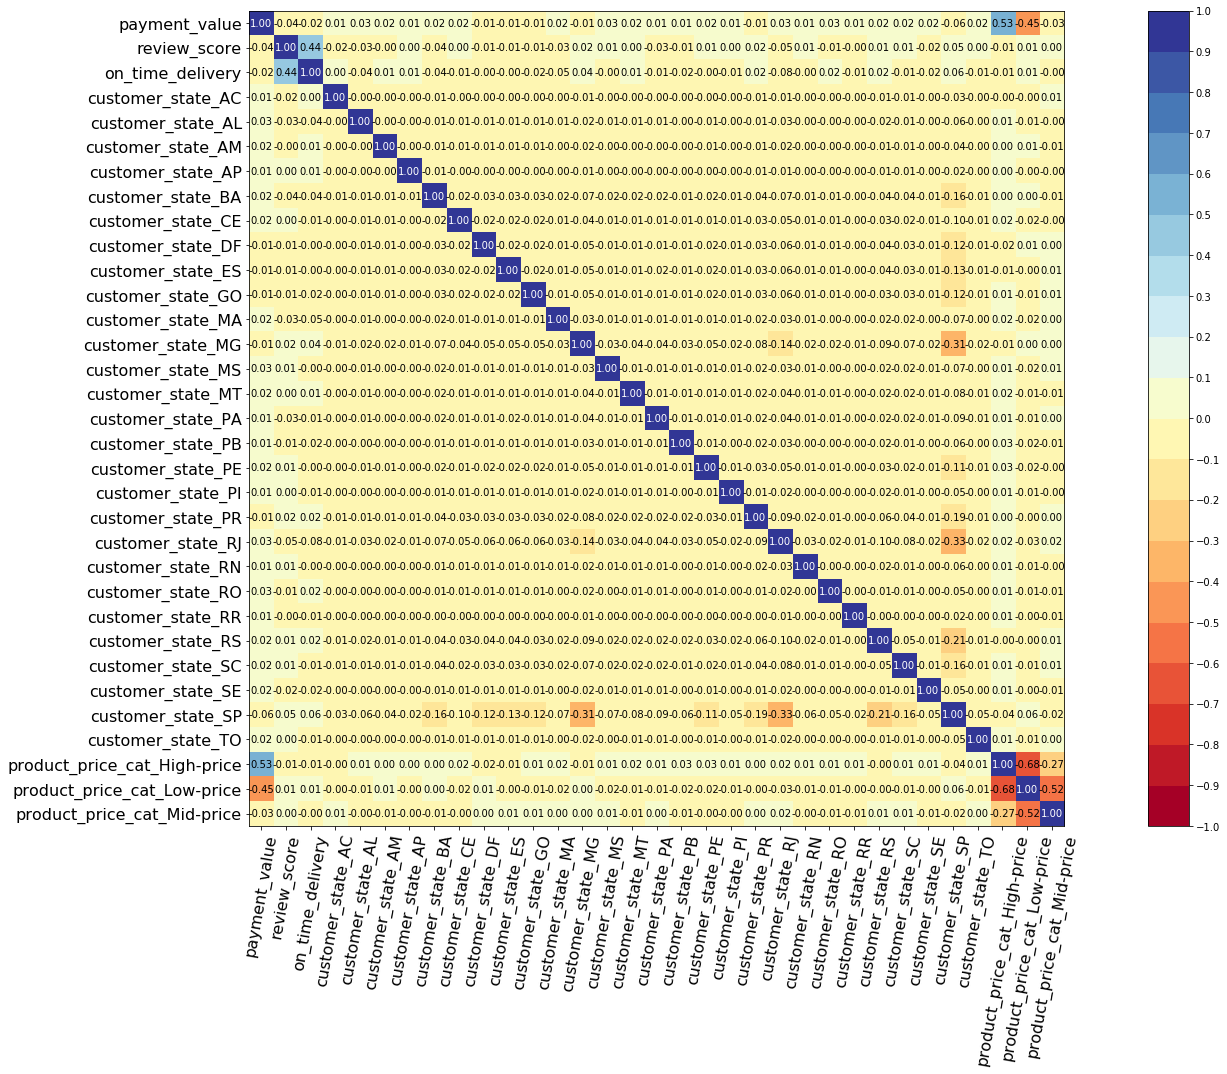

In [37]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(df_model.iloc[:,2:], figure_size=(30, 15), text_fontsize=10)

## Modelling

The data is splitted into a train and test set.

In [38]:
from sklearn.model_selection import train_test_split
time_column = 'T'
event_column = 'E'

N = df_model.shape[0]

index_train, index_test = train_test_split( range(N), test_size = 0.35)
data_train = df_model.loc[index_train].reset_index( drop = True )
data_test  = df_model.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train.iloc[:,2:], data_test.iloc[:,2:]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [39]:
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.metrics import concordance_index

In [40]:
from pysurvival.models.non_parametric import KaplanMeierModel
km = KaplanMeierModel()
km.fit(X_train, T_train, E_train)

In [41]:
from pysurvival.models.survival_forest import ExtraSurvivalTreesModel
xst = ExtraSurvivalTreesModel(num_trees=20) 
xst.fit(X_train, T_train, E_train,
        max_features='sqrt',
        max_depth=5,
        min_node_size=20,
        num_random_splits=20)

ExtraSurvivalTreesModel

In [42]:
print('Model name: {}'.format(xst.name))
# Print C-index
print('C-index: {:.3f}'.format(concordance_index(xst, X_train, T_train, E_train)))
print('C-index: {:.3f}'.format(concordance_index(xst, X_test, T_test, E_test)))

Model name: ExtraSurvivalTreesModel
C-index: 0.611
C-index: 0.545


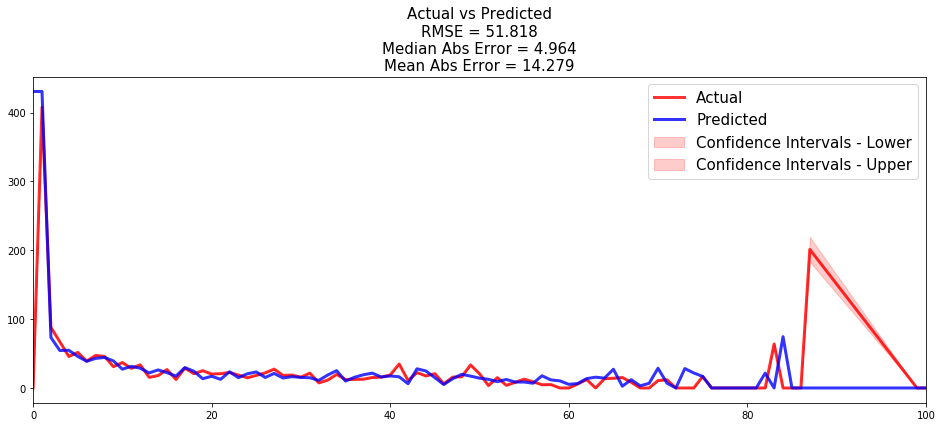

In [43]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(xst, X_test, T_test, E_test,
                            is_at_risk=False,
                            figure_size=(16, 6),
                            metrics=['rmse', 'mean', 'median'])

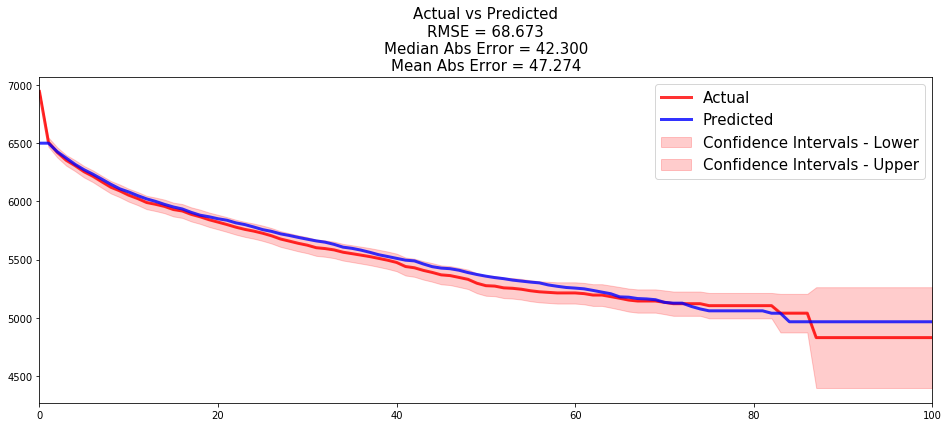

In [44]:
results = compare_to_actual(xst, X_test, T_test, E_test,
                            is_at_risk=True,
                            figure_size=(16, 6),
                            metrics=['rmse', 'mean', 'median'])

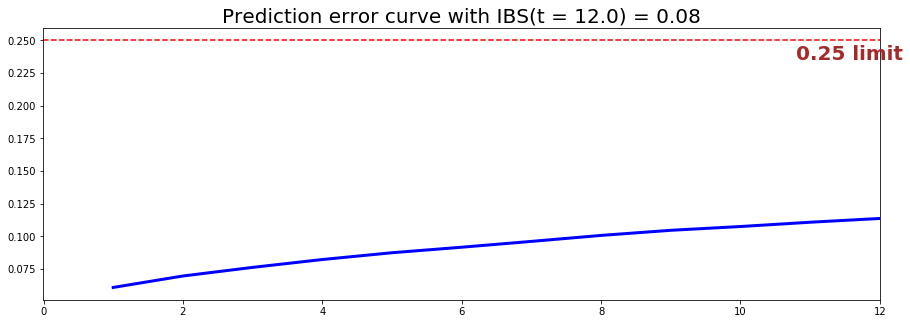

IBS: 0.085


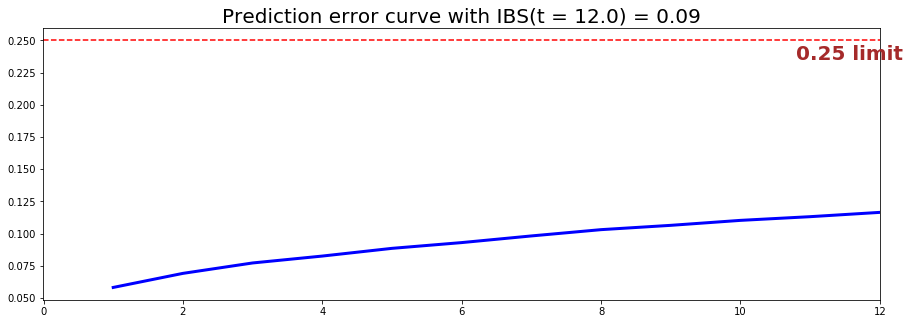

IBS: 0.086


In [45]:
# Print IBS
print('IBS: {:.3f}'.format(integrated_brier_score(xst, X_train, T_train, E_train, t_max=12, figure_size=(15, 5))))
print('IBS: {:.3f}'.format(integrated_brier_score(xst, X_test, T_test, E_test, t_max=12, figure_size=(15, 5))))

In [46]:
# Computing variables importance
xst.variable_importance_table.head(20)

,feature,importance,pct_importance
0,product_price_cat_Low-price,4.134212,0.112104
1,on_time_delivery,3.959445,0.107365
2,product_price_cat_High-price,3.868294,0.104893
3,customer_state_RS,3.259769,0.088393
4,review_score,2.997866,0.081291
5,customer_state_CE,2.932722,0.079524
6,customer_state_PE,2.238129,0.060690
7,product_price_cat_Mid-price,1.960016,0.053148
8,payment_value,1.861484,0.050476
9,customer_state_GO,1.752983,0.047534


In [47]:
from pysurvival.utils.display import create_risk_groups

KeyError: 14

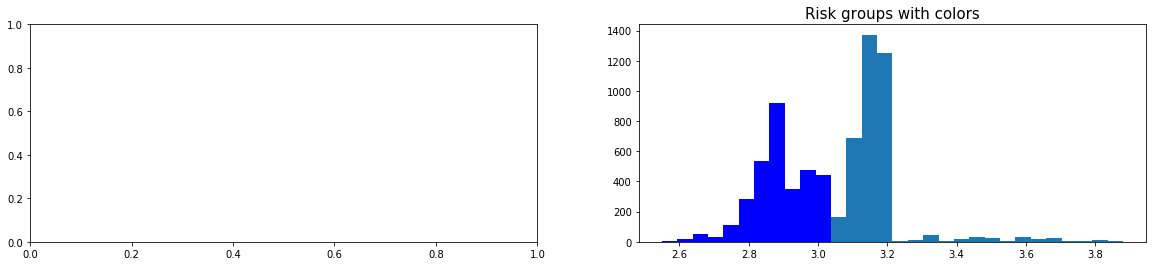

In [48]:
# Create risk groups
risk_groups = create_risk_groups(model=xst, X=X_test,
                                 use_log=True,
                                 num_bins=30,
                                 figure_size=(20, 4),
                                 low={'lower_bound': 0., 'upper_bound': 1.65, 'color': 'red'},
                                 medium={'lower_bound': 1.65, 'upper_bound': 2.2, 'color': 'green'},
                                 high={'lower_bound': 2.2, 'upper_bound': 3., 'color': 'blue'})